In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
sys.path.append("../data/embeddings/biasbios")
import classifier
import svm_classifier
import debias
# import gensim
import codecs
import json
# from gensim.models.keyedvectors import Word2VecKeyedVectors
# from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from pytorch_transformers import BertTokenizer, BertModel, BertForMaskedLM

import scipy
from scipy import linalg
from scipy import sparse
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, SGDRegressor, Perceptron, LogisticRegression

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

import warnings
warnings.filterwarnings("ignore")

import pickle
from collections import defaultdict, Counter
from typing import List, Dict

# import torch
# from torch import utils

# import pytorch_lightning as pl
# from pytorch_lightning import Trainer
import copy

import seaborn as sn
import pandas as pd

import eli5

PROFS = ['professor', 'physician', 'attorney', 'photographer', 'journalist', 'nurse', 'psychologist', 'teacher',
'dentist', 'surgeon', 'architect', 'painter', 'model', 'poet', 'filmmaker', 'software_engineer',
'accountant', 'composer', 'dietitian', 'comedian', 'chiropractor', 'pastor', 'paralegal', 'yoga_teacher',
'dj', 'interior_designer', 'personal_trainer', 'rapper']

PROF2UNIFIED_PROF = {"associate professor": "professor", "assistant professor": "professor", "software engineer": "software_engineer", "psychotherapist": "psychologist", "orthopedic surgeon": "surgeon", "trial lawyer": "attorney","plastic surgeon": "surgeon",  "trial attorney": "attorney", "senior software engineer": "software_engineer", "interior designer": "interior_designer", "certified public accountant": "accountant", "cpa": "accountant", "neurosurgeon": "surgeon", "yoga teacher": "yoga_teacher", "nutritionist": "dietitian", "personal trainer": "personal_trainer", "certified personal trainer": "personal_trainer", "yoga instructor": "yoga_teacher"}

In [2]:
# def load_data(fname = "/home/nlp/ravfogs/gender/biosbias/BIOS.pkl"):
#     with open(fname, "rb") as f:
#         data = pickle.load(f)
#     for i, data_dict in enumerate(data):
        
#         prof = data_dict["raw_title"].lower()
#         data[i]["raw_title"] = PROF2UNIFIED_PROF[prof] if prof in PROF2UNIFIED_PROF else prof
    
#     return data
        

def load_data(fname = "/home/nlp/ravfogs/gender/biosbias/BIOS.pkl"):
    with open(fname, "rb") as f:
        data = pickle.load(f)
    return data        
        
    
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["gender"], entry["raw_title"]
        counter[prof.lower()][gender.lower()] += 1
        
    return counter

def filter_dataset(data, topk = 10):
    
    filtered = []
    counter = count_profs_and_gender(data)
    total_counts = [(prof, counter[prof]["f"] + counter[prof]["m"]) for prof in counter.keys()]
    profs_by_frq = sorted(total_counts, key = lambda x: -x[1])
    topk_profs = [p[0] for p in profs_by_frq[:topk]]
    
    print("Top-k professions: {}".format(topk_profs))
    for d in data:
        
        if d["raw_title"].lower() in topk_profs:
            filtered.append(d)
    
    return filtered
    
def split_train_dev_test(data):
    
    g2i, i2g = {"m": 0, "f": 1}, {1: "f", 0: "m"}
    all_profs = list(set([d["raw_title"] for d in data]))
    all_words = []
    for d in data:
        all_words.extend(d["raw"].split(" "))
    
    all_words = set(all_words)
    all_words.add("<UNK>")
    
    p2i = {p:i for i,p in enumerate(sorted(all_profs))}
    i2p = {i:p for i,p in enumerate(sorted(all_profs))}
    w2i = {w:i for i,w in enumerate(sorted(all_words))}
    i2w = {i:w for i,w in enumerate(sorted(all_words))}
    
    all_data = []
    for entry in tqdm.tqdm(data, total = len(data)):
        gender, prof = entry["gender"].lower(), entry["raw_title"].lower()
        #if prof in PROF2UNITED_PROF: prof = PROF2UNITED_PROF[prof]
        raw, start_index = entry["raw"], entry["start_pos"]
        all_data.append({"g": g2i[gender], "p": p2i[prof], "text": raw, "start": start_index})


    train_dev, test = sklearn.model_selection.train_test_split(all_data, test_size = 0.2, random_state = 0)
    train, dev = sklearn.model_selection.train_test_split(train_dev, test_size = 0.3, random_state = 0)
    print("Train size: {}; Dev size: {}; Test size: {}".format(len(train), len(dev), len(test)))
    return (train, dev, test), (g2i, i2g, p2i, i2p, w2i, i2w)


In [3]:
def load_dictionary(path):
    
    with open(path, "r", encoding = "utf-8") as f:
        
        lines = f.readlines()
        
    k2v, v2k = {}, {}
    for line in lines:
        
        k,v = line.strip().split("\t")
        v = int(v)
        k2v[k] = v
        v2k[v] = k
    
    return k2v, v2k

In [4]:
train = load_data('/home/nlp/ravfogs/gender/code/nullspace_projection/data/biasbios/hila/train.pickle')
dev = load_data('/home/nlp/ravfogs/gender/code/nullspace_projection/data/biasbios/hila/dev.pickle')
test = load_data('/home/nlp/ravfogs/gender/code/nullspace_projection/data/biasbios/hila/test.pickle')

In [5]:
p2i, i2p = load_dictionary("/home/nlp/ravfogs/gender/code/nullspace_projection/data/biasbios/profession2index.txt")
g2i, i2g = load_dictionary("/home/nlp/ravfogs/gender/code/nullspace_projection/data/biasbios/gender2index.txt")

In [3]:
# data = load_data()
# data = filter_dataset(data, topk = 60)
# (train, dev, test), (g2i, i2g, p2i, i2p, w2i, i2w) = split_train_dev_test(data)

Top-k professions: ['professor', 'physician', 'attorney', 'photographer', 'journalist', 'nurse', 'psychologist', 'teacher', 'surgeon', 'dentist', 'architect', 'painter', 'model', 'poet', 'filmmaker', 'software_engineer', 'composer', 'accountant', 'dietitian', 'comedian', 'pastor', 'chiropractor', 'yoga_teacher', 'paralegal', 'dj', 'interior_designer', 'personal_trainer', 'rapper']


100%|██████████| 312594/312594 [00:00<00:00, 530939.95it/s]


Train size: 175052; Dev size: 75023; Test size: 62519


In [4]:
# def normalize_text(data):
#     for entry in data:
#         text, start, y = entry["text"], entry["start"], entry["p"]
#         #text = text.lower()
#         words = text[start + 1:].split(" ")
#         entry['hard_text'] = ' '.join(words)
#     return data

In [111]:
# train = normalize_text(train)
# dev = normalize_text(dev)

In [6]:
train[0]

{'g': 'f',
 'p': 'teacher',
 'text': 'Hawa Sabriye is an Occasional Teacher with the Toronto District School Board and is currently completing her Masters of Education at York University. She has been working with children in camp, community and school settings for the past 8 years. She believes in the importance of cultivating self-love and awareness in black children at a very young age and is excited to be apart of Black Lives Matter Toronto’s Freedom School!',
 'start': 149,
 'hard_text': 'She has been working with children in camp , community and school settings for the past 8 years . She believes in the importance of cultivating self - love and awareness in black children at a very young age and is excited to be apart of Black Lives Matter Toronto ’s Freedom School !',
 'hard_text_untokenized': 'She has been working with children in camp, community and school settings for the past 8 years. She believes in the importance of cultivating self-love and awareness in black children at 

In [7]:
print(p2i)

{'accountant': 0, 'architect': 1, 'attorney': 2, 'chiropractor': 3, 'comedian': 4, 'composer': 5, 'dentist': 6, 'dietitian': 7, 'dj': 8, 'filmmaker': 9, 'interior_designer': 10, 'journalist': 11, 'model': 12, 'nurse': 13, 'painter': 14, 'paralegal': 15, 'pastor': 16, 'personal_trainer': 17, 'photographer': 18, 'physician': 19, 'poet': 20, 'professor': 21, 'psychologist': 22, 'rapper': 23, 'software_engineer': 24, 'surgeon': 25, 'teacher': 26, 'yoga_teacher': 27}


### get input representatons 

In [8]:
import nltk

def nltk_tokenization(text):
    tokens = nltk.word_tokenize(text)
    return tokens

def built_in_tokenization(text):
    tokens = text.split()
    return tokens

In [9]:
%%time
x_train = [x['hard_text'] for x in train]
y_train = [x['p'] for x in train]

x_dev = [x['hard_text'] for x in dev]
y_dev = [x['p'] for x in dev]

clf = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=built_in_tokenization)),
    ('selection', SelectKBest(chi2, k=10000)),
#     ('classifier', LogisticRegression())
    ('classifier', SGDClassifier(warm_start=True, loss='log', n_jobs=64, max_iter=75, random_state=0))
])

clf.fit(x_train, y_train)
clf.score(x_dev, y_dev)

CPU times: user 6min 38s, sys: 5.63 s, total: 6min 43s
Wall time: 31.1 s


0.7942543625695344

In [137]:
x_test = [x['hard_text'] for x in test]
y_test = [x['p'] for x in test]

#### Confusion Matrix

In [10]:
y_hat = clf.predict(x_dev)
cm = sklearn.metrics.confusion_matrix(y_dev,y_hat)
labels = [i2p[i] for i in range(len(i2p))]

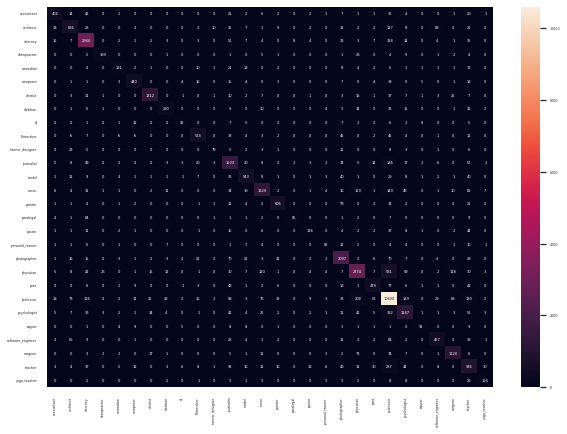

In [11]:
df_cm = pd.DataFrame(cm, index = labels, columns = labels)
#plt.figure(figsize = (10,7))
sn.set(font_scale=0.3)#for label size
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')
# plt.savefig("confusion.png", dpi = 600)
plt.show()

### feature inspection

### perform debiasing

In [15]:
def get_projection_matrix(num_clfs, X_train, Y_train, X_dev, Y_dev, Y_train_main, Y_dev_main, dim=300):

    is_autoregressive = True
    reg = "l2"
    min_acc = 0.
    noise = False
    random_subset = False
    regression = False
    
    clf = SGDClassifier
    params = {'warm_start': True, 'loss': 'log', 'n_jobs': 64, 'max_iter': 75, 'random_state': 0}
#     clf = LinearSVC
#     params = {'max_iter': 10, 'fit_intercept': True, 'class_weight': "balanced", "dual": False, "penalty": reg, 
#              'C': 2}

    P = debias.get_debiasing_projection(clf, params, num_clfs, dim, is_autoregressive,
                                           min_acc, X_train, Y_train, X_dev, Y_dev, noise=noise,
                                           by_class=True, Y_train_main=Y_train_main, Y_dev_main=Y_dev_main)
    return P



num_clfs = 100
Y_dev_gender = np.array([d["g"] for d in dev])
Y_train_gender = np.array([d["g"] for d in train])
Y_dev_prof = np.array([d["p"] for d in dev])
Y_train_prof = np.array([d["p"] for d in train])

n_examples = 50000

In [13]:
x_train_one_hot = clf.named_steps['selection'].transform(clf.named_steps['vectorizer'].transform([x['hard_text'] for x in train]))
x_dev_one_hot = clf.named_steps['selection'].transform(clf.named_steps['vectorizer'].transform([x['hard_text'] for x in dev]))

In [16]:
%%time

P = get_projection_matrix(num_clfs, x_train_one_hot[:n_examples],
                          Y_train_gender[:n_examples], x_dev_one_hot, Y_dev_gender[:n_examples],
                             Y_train_prof[:n_examples], Y_dev_prof[:n_examples], dim = 10000)

iteration: 99, accuracy: 0.5480020318320352: 100%|██████████| 100/100 [1:36:10<00:00, 57.71s/it]

CPU times: user 1d 19h 57min 52s, sys: 7h 52min 3s, total: 2d 3h 49min 56s
Wall time: 1h 36min 11s


In [17]:
P

array([[ 1.00000000e+00,  1.23282518e-18,  2.47817808e-16, ...,
         0.00000000e+00,  0.00000000e+00, -1.75103432e-17],
       [ 3.92680846e-17,  9.47108419e-01, -3.22534691e-03, ...,
         0.00000000e+00,  0.00000000e+00,  2.89768349e-04],
       [ 2.34601120e-16, -3.22534691e-03,  9.67039031e-01, ...,
         0.00000000e+00,  0.00000000e+00,  7.49785060e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [-2.29174436e-17,  2.89768349e-04,  7.49785060e-04, ...,
         0.00000000e+00,  0.00000000e+00,  9.89884833e-01]])

In [18]:
clf

Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
       ...andom_state=0, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=True))])

In [19]:
np.save('P_final.npy', P)

### New model - with debisaing

In [22]:
from sklearn.base import BaseEstimator, ClassifierMixin

class DebiasClassifier(BaseEstimator, ClassifierMixin):  
    """An example of classifier"""

    def __init__(self, w):
        """
        Called when initializing the classifier
        """
        self.w = w

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.

        Note: assert is not a good choice here and you should rather
        use try/except blog with exceptions. This is just for short syntax.
        """

        raise Exception

    def _meaning(self, x):
        # returns True/False according to fitted classifier
        # notice underscore on the beginning
        return( True if x >= self.treshold_ else False )

    def predict(self, X, y=None):
        return X * self.w
    
    def transform(self, X):
        return X * self.w

    def score(self, X, y=None):
        # counts number of values bigger than mean
        return(sum(self.predict(X))) 

In [23]:
from eli5 import transform_feature_names

@transform_feature_names.register(DebiasClassifier)
def indexer_feature_names(transformer, in_names=None):
    assert in_names is not None  # don't handle it for now
    print(transformer)
    return ["StringIndexer(%s)" % name for name in in_names]

In [25]:
svc = clf.named_steps['classifier']

In [36]:
from copy import deepcopy

debiased_svc = deepcopy(svc)

In [37]:
# debiased_svc.coef_ = svc.coef_.dot(P.T)
debiased_svc.coef_ = P.dot(svc.coef_.T).T

In [38]:
debias_clf = Pipeline([
    ('vectorizer', clf.named_steps['vectorizer']),
    ('selection', clf.named_steps['selection']),
    ('classifier', debiased_svc),
])

In [39]:
clf.score(x_dev, y_dev)

0.7942543625695344

In [40]:
debias_clf.score(x_dev, y_dev)

0.78099519926846

In [41]:
eli5.show_weights(clf, target_names=list(p2i.keys()))

In [42]:
eli5.show_weights(debias_clf, target_names=list(p2i.keys()))

In [41]:
temp = Pipeline([
    ('vectorizer', clf.named_steps['vectorizer']),
    ('selection', clf.named_steps['selection']),
])

In [108]:
clf.named_steps['selection'].transform(clf.named_steps['vectorizer'].transform([x_dev[0]]))

<1x15000 sparse matrix of type '<class 'numpy.int64'>'
	with 34 stored elements in Compressed Sparse Row format>

In [112]:
eli5.show_prediction(clf, 
                     x_dev[0],# vec=temp,
                    target_names=list(p2i.keys()),
                    force_weights=False)

In [146]:
clf.predict(x_train[:10])

array([ 1, 21, 14, 25,  2, 25,  2,  2, 18, 20])

In [141]:
x_temp = clf.named_steps['selection'].transform(clf.named_steps['vectorizer'].transform(x_dev[4:5]))
eli5.show_prediction(clf.named_steps['classifier'] , 
                     x_temp,# vec=temp,
                     feature_names=feat_names[selector.get_support()],
                    target_names=list(p2i.keys()),
                    force_weights=False
                    )

In [142]:
x_temp = debias_clf.named_steps['selection'].transform(debias_clf.named_steps['vectorizer'].transform(x_dev[4:5]))
eli5.show_prediction(debias_clf.named_steps['classifier'] , 
                     x_temp,# vec=temp,
                     feature_names=feat_names[selector.get_support()],
                    target_names=list(p2i.keys()),
                    force_weights=False
                    )

In [244]:
eli5.show_prediction(debias_clf.named_steps['classifier'] , x_dev[8], vec=debias_clf.named_steps['vectorizer'],
                    target_names=list(p2i.keys()))

#### test model without finetuning

In [43]:
clf.score(x_dev, y_dev)

0.7942543625695344

In [44]:
debias_clf.score(x_dev, y_dev)

0.78099519926846

In [308]:
acc_test_bias = clf.score(x_test, y_test)
acc_test_debias = debias_clf.score(x_test, y_test)

print(acc_test_bias, acc_test_debias, acc_test_bias - acc_test_debias)

0.7969372813796469 0.7839319124705116 0.013005368909135284


In [45]:
reg_cls = clf.named_steps['classifier']
debias_cls = debias_clf.named_steps['classifier']

In [48]:
vectorizer = clf.named_steps['vectorizer']

In [49]:
selector = clf.named_steps['selection']

In [50]:
feat_names = np.array(vectorizer.get_feature_names())

In [51]:
did_change = ((reg_cls.coef_ * debias_cls.coef_) < 0)[0]

In [52]:
feat_names[selector.get_support()][did_change]

array(['+44', '1981', '1988', '19th', '2.0', '2.5', '200-hr', '200hr',
       '2014', '2018', '203', '208', '20th', '217', '219', '223', '2273',
       '239', '2511', '253', '256', '2727', '276', '28', '284', '303',
       '310', '314', '319', '322', '33', '334', '336', '3506', '386',
       '3ho', '4.0', '4.5', '4000', '414', '419', '444', '500-hr', '502',
       '503', '507', '541', '561', '574', '585', '601', '606', '608',
       '609', '614', '631', '636', '651', '701', '712', '713', '717',
       '724', '731', '734', '757', '763', '781', '785', '8000', '808',
       '812', '825', '828', '864', '865', '882', '901', '907', '913',
       '919', '928', '972', 'a', 'a&m', 'a&r', 'achalasia', 'acl', 'act',
       'ada', 'adaa', 'adajan', 'adaptive', 'adventist', 'advocated',
       'affects', 'again', 'agarwal', 'ago', 'ahlia', 'akhanda',
       'alcohol', 'aldeburgh', 'alexius', 'algebra', 'alpi', 'alta',
       'amerigroup', 'amicus', 'amritsar', 'amyee', 'analyzer', 'ancc',
       'a

In [53]:
c = 0
for i in range(28):
    did_change = ((reg_cls.coef_ * debias_cls.coef_) < 0)[i]
    gender = False
    for w in feat_names[selector.get_support()][did_change]:
        if w in ['she', 'he', 'her', 'him']:
            gender = True
            c += 1
            break
print(c)

22


### Fine tune the debiased model

In [130]:
selector.transform(vectorizer.transform(x_dev))

<39369x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 1601663 stored elements in Compressed Sparse Row format>

### Features Flip

In [54]:
def flip_features(clf1, clf2, feature_names):
    (clf1.coef_ * clf2.coef_) < 0

### Maximum weight change

In [55]:
np.argsort(np.abs(debias_cls.coef_ - reg_cls.coef_)[0, :])[::-1]

array([9820, 6033,  943, ..., 4486, 4474, 4999])

In [56]:
# a specific profession most changed words
for ind in np.argsort(np.abs(debias_cls.coef_ - reg_cls.coef_)[2, :])[::-1][:20]:
    print(feat_names[selector.get_support()][ind])

includes
health
by
practice
enjoys
air
ms.
patients
teaching
classes
early
or
gender
school
mr.
that
pennsylvania
clinical
choice
women


In [57]:
feature_names = feat_names[selector.get_support()]
coefs_diff = np.abs(debias_cls.coef_ - reg_cls.coef_)

In [58]:
top_debiased_words = defaultdict(int)
for i in range(reg_cls.coef_.shape[0]):
    for ind_val, index in enumerate(np.argsort(coefs_diff[i, :])[::-1][:10000]):
        top_debiased_words[feature_names[index]] += ind_val
        
for k, v in top_debiased_words.items():
    top_debiased_words[k] /= float(reg_cls.coef_.shape[0])

In [60]:
top_debiased_words

defaultdict(int,
            {'women': 658.75,
             'ms.': 415.2857142857143,
             'association': 825.5714285714286,
             'responsible': 1719.857142857143,
             'by': 353.07142857142856,
             'clinical': 671.7857142857143,
             'her': 156.0,
             'technology': 1591.7857142857142,
             'that': 1178.7142857142858,
             'education': 412.60714285714283,
             'writing': 1470.142857142857,
             'literature': 842.8928571428571,
             'van': 1021.1785714285714,
             'includes': 1293.5714285714287,
             'gender': 1083.9285714285713,
             'mr.': 664.5,
             'research': 934.8214285714286,
             'years': 907.4642857142857,
             'health': 664.4642857142857,
             'science': 595.7142857142857,
             'security': 1648.9642857142858,
             'degree': 840.5357142857143,
             'immigration': 1955.4642857142858,
             'work': 1077.0

In [61]:
import operator
# x = {1: 2, 3: 4, 4: 3, 2: 1, 0: 0}
sorted_x = sorted(top_debiased_words.items(), key=operator.itemgetter(1))
print([x[0] for x in sorted_x[:100]])

['her', 'she', 'this', 'interests', 'by', 'education', 'ms.', 'his', 'dr.', 'community', 'ms', 'science', 'david', 'their', '2015', 'women', '/', 'health', 'mr.', 'clinical', 'he', '&', 'during', 'node.js', 'state', 'high', 'healthy', 'choice', 'photography', '2012', 'association', 'sciences', 'degree', 'literature', 'states', 'and', 'also', 'management', 'include', 'years', 'mrs.', 'nursing', 'art', 'about', 'research', 'born', 'patients', 'show', 'career', 'fellow', '!', 'based', 'between', 'one', 'graduate', 'won', 'south', 'focuses', ':', 'well', 'coach', 'van', 'how', 'or', 'virginia', 'institute', 'teaching', 'worked', 'north', 'work', 'department', 'gender', '”', 'regional', 'who', 'areas', 'interested', 'working', 'focus', "'", 'family', 'robert', 'communication', 'industry', 'review', 'that', 'for', 'active', 'resources', 'still', 'mainly', 'master', 'social', 'city', 'analysis', 'inc.', 'passion', 'practice', 'mississippi', 'communities']


In [310]:
for ind, (x, _) in enumerate(sorted_x[:100]):
    print(x + ', ', end='')
    if ind > 0 and ind % 6 == 0:
        print('\\\\')

her, she, this, interests, by, education, ms., \\
his, dr., community, ms, science, david, \\
their, 2015, women, /, health, mr., \\
clinical, he, &, during, node.js, state, \\
high, healthy, choice, photography, 2012, association, \\
sciences, degree, literature, states, and, also, \\
management, include, years, mrs., nursing, art, \\
about, research, born, patients, show, career, \\
fellow, !, based, between, one, graduate, \\
won, south, focuses, :, well, coach, \\
van, how, or, virginia, institute, teaching, \\
worked, north, work, department, gender, ”, \\
regional, who, areas, interested, working, focus, \\
', family, robert, communication, industry, review, \\
that, for, active, resources, still, mainly, \\
master, social, city, analysis, inc., passion, \\
practice, mississippi, communities, 

In [272]:
def read_gender_file(in_f):
    with open(in_f) as f:
        data = f.read()
    gender_words = data.strip()[1:-1].replace('\'', '').replace(' ', '').split(',')
    gender_words = list(filter(lambda x: len(x.split('_')) == 1, gender_words))
    return gender_words    
        
    
female_words = read_gender_file('female.1500.txt')
male_words = read_gender_file('male.1500.txt')
no_gender_words = read_gender_file('no_gender_words.txt')

In [273]:
male_words[:10]

['journeyman',
 'hero',
 'burly',
 'goatee',
 'rookie',
 'affable',
 'swashbuckling',
 'maestro',
 'scout',
 'jnr']

In [274]:
female_words[:10]

['mommies',
 'ditzy',
 'alumna',
 'motherly',
 'petite',
 'beautician',
 'comedienne',
 'perky',
 'lipsticks',
 'mums']

In [275]:
no_gender_words[:10]

['g',
 'etw',
 'dias',
 'fratelli',
 'gcw',
 'gank',
 'balthazar',
 'était',
 'martone',
 'rune']

In [182]:
with open('self_vocab.txt', 'w') as f:
    for x in feat_names[selector.get_support()]:
        f.write(x + '\n')

In [169]:
no_gender_words, gendered_words = no_gender_words[:1500], no_gender_words[1500:]

In [276]:
gendered_words = male_words + female_words

feats_name_10k = feat_names[selector.get_support()]
gendered_feats = []
for gen in gendered_words:
    val = np.where(feats_name_10k == gen)[0]
    if len(val) > 0:
        gendered_feats.append(val[0])
#     if gen in feats_name_10k:


In [277]:
no_gendered_feats = []
for gen in no_gender_words:
    val = np.where(feats_name_10k == gen)[0]
    if len(val) > 0:
        no_gendered_feats.append(val[0])

In [292]:
np.random.seed(1)
no_gendered_feats = np.random.randint(10000, size=300)

In [189]:
len(gendered_feats)

392

In [190]:
len(no_gendered_feats)

225

In [278]:
gender_change = 0
gender_change_list = np.abs(debias_cls.coef_ - reg_cls.coef_)[0, :]
for ind in gendered_feats:
    gender_change += gender_change_list[ind]
    
gender_change /= len(gendered_feats)
print(gender_change)

0.011495830506628847


In [279]:
gender_change_list.mean()

0.008688522847835358

In [280]:
gender_change / gender_change_list.mean()

1.3231052858994203

In [209]:
0.007703681749280306 / 0.005259555902612593

1.464701942887162

In [223]:
debias_cls.coef_.shape

(28, 10000)

In [202]:
np.abs(debias_cls.coef_ - reg_cls.coef_)[0, :].shape

(10000,)

In [205]:
max(gendered_feats)

9920

In [216]:
np.abs(debias_cls.coef_ - reg_cls.coef_)[0, :]

array([1.37303363e-15, 2.85728419e-02, 1.17998981e-02, ...,
       0.00000000e+00, 0.00000000e+00, 3.11603465e-02])

In [249]:
temp = ((debias_cls.coef_ / reg_cls.coef_)[0, :] < 1).astype(int)
temp[temp == 0] = -1
temp

array([-1,  1, -1, ..., -1, -1, -1])

In [219]:
debias_cls.coef_

array([[-5.52069376e-03, -2.29715277e-01, -2.00593415e-01, ...,
        -1.25887665e-03, -5.12919313e-05, -7.32037544e-02],
       [-8.91700638e-03, -1.50095799e-01, -2.90985944e-02, ...,
        -4.16467872e-03, -5.26572251e-05,  1.12897198e-02],
       [-3.04820304e-02,  9.41210576e-03,  3.62622048e-02, ...,
        -7.51100353e-03, -2.68227110e-05, -1.16176297e-01],
       ...,
       [-3.28095289e-04, -3.41718187e-01, -1.60267980e-01, ...,
        -1.84398041e-03, -7.00587179e-04,  9.01606501e-02],
       [-4.00795482e-03,  1.07800163e-01,  7.73726221e-02, ...,
        -1.53166911e-02, -2.85389327e-05, -8.35399834e-02],
       [-8.98162355e-05, -5.92686569e-02, -1.38064480e-01, ...,
        -1.81053433e-04, -1.87167599e-06,  9.12750000e-02]])

In [220]:
reg_cls.coef_

array([[-5.52069376e-03, -2.58288119e-01, -1.88793517e-01, ...,
        -1.25887665e-03, -5.12919313e-05, -4.20434079e-02],
       [-8.91700638e-03, -1.83845869e-01, -3.78910728e-02, ...,
        -4.16467872e-03, -5.26572251e-05,  1.42308974e-02],
       [-3.04820304e-02, -9.46108493e-02,  2.66369678e-02, ...,
        -7.51100353e-03, -2.68227110e-05, -9.05156124e-02],
       ...,
       [-3.28095289e-04, -3.79461172e-01, -1.61095976e-01, ...,
        -1.84398041e-03, -7.00587179e-04,  1.01138983e-01],
       [-4.00795482e-03,  9.91220195e-02,  4.70101714e-03, ...,
        -1.53166911e-02, -2.85389327e-05, -5.45654424e-02],
       [-8.98162355e-05, -8.34453739e-02, -1.92141316e-01, ...,
        -1.81053433e-04, -1.87167599e-06,  9.98650528e-02]])

In [215]:
debias_cls.coef_[0, :]

array([-5.52069376e-03, -2.29715277e-01, -2.00593415e-01, ...,
       -1.25887665e-03, -5.12919313e-05, -7.32037544e-02])

In [214]:
reg_cls.coef_[0, :]

array([-5.52069376e-03, -2.58288119e-01, -1.88793517e-01, ...,
       -1.25887665e-03, -5.12919313e-05, -4.20434079e-02])

In [281]:
# p2i
profession_change = []
for i in range(reg_cls.coef_.shape[0]):
    gender_change_list = np.abs(debias_cls.coef_ - reg_cls.coef_)[i, :]
#     temp = ((debias_cls.coef_ / reg_cls.coef_)[i, :] < 1).astype(int)
#     temp[temp == 0] = -1
#     gender_change_list = gender_change_list * temp
#     gender_change_list = (reg_cls.coef_ - debias_cls.coef_)[i, :] / reg_cls.coef_[i, :]
    gender_change = 0
    for ind in gendered_feats:
        gender_change += gender_change_list[ind]
    gender_change /= len(gendered_feats)
    profession_change.append(gender_change)

In [282]:
profession_change

[0.011495830506628847,
 0.016200341639234478,
 0.018244654058825298,
 0.009643095859945296,
 0.011553617685249325,
 0.011691982155757449,
 0.011745741087657765,
 0.009689640971488818,
 0.01423315113889732,
 0.00996780999516568,
 0.009221685982002698,
 0.01760716685620102,
 0.01660791790994622,
 0.011611708701516796,
 0.012205978904003314,
 0.010795431891440315,
 0.011072998923454083,
 0.008974213839702164,
 0.012989682491528355,
 0.01526995197118697,
 0.011832083456912439,
 0.019632357086778043,
 0.014248036120578365,
 0.00935197830958623,
 0.016143843305785346,
 0.012975044530505188,
 0.014953717561263557,
 0.009369916445596836]

In [293]:
profession_no_change = []
for i in range(reg_cls.coef_.shape[0]):
    gender_unchange_list = np.abs(debias_cls.coef_ - reg_cls.coef_)[i, :]
#     gender_unchange_list = (reg_cls.coef_ - debias_cls.coef_)[i, :] / reg_cls.coef_[i, :]
#     temp = ((debias_cls.coef_ / reg_cls.coef_)[i, :] < 1).astype(int)
#     temp[temp == 0] = -1
#     gender_unchange_list = gender_unchange_list * temp
    
    gender_unchange = 0
    for ind in no_gendered_feats:
        gender_unchange += gender_unchange_list[ind]
    gender_unchange /= len(no_gendered_feats)
    profession_no_change.append(gender_unchange)

In [294]:
mean_word_change = np.abs(debias_cls.coef_ - reg_cls.coef_).mean(axis=1)
# temp = ((debias_cls.coef_ / reg_cls.coef_) < 1).astype(int)
# temp[temp == 0] = -1
# mean_word_change = mean_word_change * temp
# mean_word_change = mean_word_change.mean(axis=1)
# mean_word_change = ((reg_cls.coef_ - debias_cls.coef_) / reg_cls.coef_).mean(axis=1)

profession_change_diff = np.array(profession_change) / mean_word_change

profession_unchange_diff = np.array(profession_no_change) / mean_word_change

In [323]:
import seaborn as sns
sns.set(style="darkgrid")

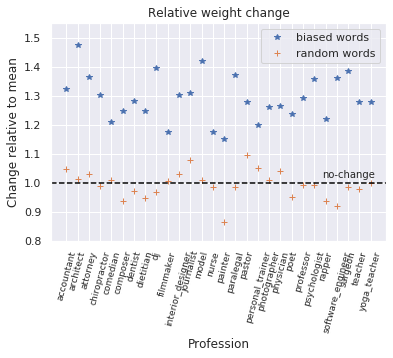

In [352]:

def data2plot(change, unchange, professions):
    

#     ax = plt.plot(professions, [1] * len(change), '.--', label='mean change')
    ax = plt.plot(professions, change, '*:', label='biased words', linestyle='None')
    ax = plt.plot(professions, unchange, '+:', label='random words', linestyle='None')

#     plt.annotate('100%', size=8,
#     ha = 'center', va = 'bottom',
#     xytext = (65, 0.455),
#     xy = (75.2, 0.479),
#     arrowprops = { 'facecolor' : 'black', 'shrink' : 0.001, 'width': 0.5, 'headwidth': 6, 'headlength': 8 })

    plt.ylabel('Change relative to mean')
    plt.xlabel('Profession')
    plt.title('Relative weight change')
    
    plt.axhline(y=1, xmax=1.0, color='black', ls='--')
    plt.text(25, 1.025, 'no-change', fontsize=10, va='center', ha='center')#, backgroundcolor='')
    
#     plt.ylim(0.5,0.90)
    plt.legend()
    plt.xticks(rotation=75, fontsize=9)
    plt.ylim(0.8, 1.55)
    
    plt.savefig('diff_change.pdf', bbox_inches='tight')
    plt.show()
    
data2plot(profession_change_diff, profession_unchange_diff, list(p2i.keys()))

In [348]:
profession_change_diff.mean()

1.2912870995418788

In [349]:
profession_unchange_diff.mean()

0.9929417957321289

### TPR Calc

In [115]:
def count_profs_and_gender(data: List[dict]):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter

prof_gender_count = count_profs_and_gender(train+dev+test)

In [116]:
i2p

{0: 'accountant',
 1: 'architect',
 2: 'attorney',
 3: 'chiropractor',
 4: 'comedian',
 5: 'composer',
 6: 'dentist',
 7: 'dietitian',
 8: 'dj',
 9: 'filmmaker',
 10: 'interior_designer',
 11: 'journalist',
 12: 'model',
 13: 'nurse',
 14: 'painter',
 15: 'paralegal',
 16: 'pastor',
 17: 'personal_trainer',
 18: 'photographer',
 19: 'physician',
 20: 'poet',
 21: 'professor',
 22: 'psychologist',
 23: 'rapper',
 24: 'software_engineer',
 25: 'surgeon',
 26: 'teacher',
 27: 'yoga_teacher'}

In [117]:
prof_gender_count

defaultdict(collections.Counter,
            {'teacher': Counter({'f': 9768, 'm': 6428}),
             'professor': Counter({'m': 64820, 'f': 53290}),
             'attorney': Counter({'m': 20113, 'f': 12494}),
             'surgeon': Counter({'f': 1972, 'm': 11301}),
             'photographer': Counter({'m': 15635, 'f': 8689}),
             'painter': Counter({'f': 3543, 'm': 4193}),
             'psychologist': Counter({'m': 6910, 'f': 11385}),
             'filmmaker': Counter({'f': 2310, 'm': 4699}),
             'physician': Counter({'m': 18986, 'f': 19579}),
             'interior_designer': Counter({'f': 1183, 'm': 280}),
             'architect': Counter({'m': 7715, 'f': 2398}),
             'dietitian': Counter({'f': 3689, 'm': 289}),
             'pastor': Counter({'m': 1923, 'f': 609}),
             'rapper': Counter({'m': 1271, 'f': 136}),
             'journalist': Counter({'m': 10077, 'f': 9873}),
             'dentist': Counter({'m': 9326, 'f': 5153}),
             'acc

In [118]:
f,m = 0., 0.
prof2fem = dict()

for k, values in prof_gender_count.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])

print(f / (f + m))
print(prof2fem)

0.46286566875856267
{'teacher': 0.603111879476414, 'professor': 0.45118956904580476, 'attorney': 0.38316925813475633, 'surgeon': 0.14857228961048746, 'photographer': 0.35721920736720936, 'painter': 0.4579886246122027, 'psychologist': 0.6223011751844766, 'filmmaker': 0.3295762590954487, 'physician': 0.507688318423441, 'interior_designer': 0.8086124401913876, 'architect': 0.23712053792148718, 'dietitian': 0.9273504273504274, 'pastor': 0.24052132701421802, 'rapper': 0.09665955934612651, 'journalist': 0.49488721804511276, 'dentist': 0.35589474411216243, 'accountant': 0.36818825194621374, 'poet': 0.49080017115960634, 'model': 0.8283124500133298, 'nurse': 0.9085446207369142, 'chiropractor': 0.26558891454965355, 'yoga_teacher': 0.8454600120264583, 'software_engineer': 0.1576889661164205, 'paralegal': 0.8483305036785512, 'composer': 0.16392857142857142, 'personal_trainer': 0.45670391061452514, 'comedian': 0.21150410861021793, 'dj': 0.1420875420875421}


In [179]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[i2p[y]][g] += 1
        
        prof_count_total[i2p[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict[0], scores_dict[1]
        prof_total_f = prof_count_total[profession][1]
        prof_total_m = prof_count_total[profession][0]
        tpr_m = good_m / prof_total_m
        tpr_f = good_f / prof_total_f
        
        tprs[profession][0] = tpr_m
        tprs[profession][1] = tpr_f
        tprs_ratio.append(tpr_m/tpr_f)
        tprs_change[profession] = tpr_m - tpr_f
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

In [119]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        
        if y == y_hat:
            
            scores[p2i[y]][g] += 1
        
        prof_count_total[p2i[y]][g] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(tpr_m/tpr_f)
        tprs_change[profession] = tpr_m - tpr_f
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))


In [123]:
k = len(dev)
y_pred = debias_clf.predict(x_dev[:k])
tprs_debias, tprs_change_debias, mean_tprs_debias = get_TPR(y_pred, y_dev[:k], p2i, i2p, [x['g'] for x in dev[:k]])

In [120]:
k = len(dev)
y_pred = clf.predict(x_dev[:k])
tprs_biased, tprs_change_biased, mean_tprs_biased = get_TPR(y_pred, y_dev[:k], p2i, i2p, [x['g'] for x in dev[:k]])

In [148]:
k = len(test)
y_pred = clf.predict(x_test[:k])
tprs_biased, tprs_change_biased, mean_tprs_biased = get_TPR(y_pred, y_test[:k], p2i, i2p, [x['g'] for x in test[:k]])

In [152]:
k = len(test)
y_pred = debias_clf.predict(x_test[:k])
tprs_debias, tprs_change_debias, mean_tprs_debias = get_TPR(y_pred, y_test[:k], p2i, i2p, [x['g'] for x in test[:k]])

In [124]:
def similarity_vs_tpr(tprs, title, measure, prof2fem):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[i2p[p]] for p in professions]
    
#     print(sim_lst)
    print(tpr_lst)

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 13)
    plt.ylabel("{}_diff_female {}".format(measure, title), fontsize = 13)
#     for p in professions:
#         x,y = prof2fem[p], tprs[p]
#         plt.annotate(p , (x,y), size = 4, color = "red")
#     plt.savefig("{}_vs_bias_{}".format(measure, title), dpi = 600)
    print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
    plt.show()

[0.02460543059983822, -8.197175583724015e-05, -0.1052560801101976, 0.11343135920428404, -0.17749602070785886, -0.10477520781123761, -0.03664290106529722, 0.10745779793398841, 0.11992699743139112, 0.025739599547147107, -0.03601370847818164, -0.04641349299525965, -0.036043094086318894, 0.2231861895434593, 0.07655712379748614, -0.024410240828151242, 0.003742786858863867, 0.0432728647014361, 0.0033082176302314803, -0.4387522693513781, -0.31832496382670866, 0.26850453172205435, 0.38852067868504775, 0.0031228048055620405, -0.4036521041165004, -0.1487179487179487, -0.15233262108262113, 0.046108663729809096]
Correlation: -0.8681252381169198; p-value: 2.17337904989337e-09


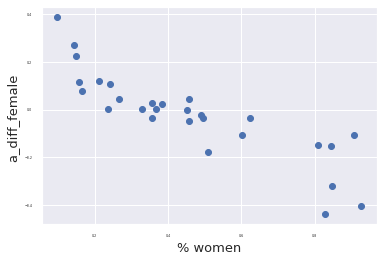

In [319]:
similarity_vs_tpr(tprs_change_biased, '', 'a', prof2fem)

[-0.001101117745139768, 0.0038532853011150614, -0.06021588780926829, 0.05980153579028791, -0.20777854489995717, -0.04624570340851519, -0.0367303185920127, 0.026983912396917664, 0.0009092009791010769, -0.1125356125356125, -0.020167810681189335, -0.02209590300181563, -0.0045759896614553375, 0.1251513222226623, -0.04641095316573607, -0.017502282143107895, -0.04260463215687105, -0.030259558130445785, 0.02393550012597634, 0.021206013269505386, -0.3074764812675359, -0.2060175334070985, 0.19629909365558912, -0.020297105495415968, -0.2976436188510492, 0.05153846153846159, 0.07741251325556736, 0.018987913701570103]
Correlation: -0.7028056327835337; p-value: 3.0436173284480794e-05


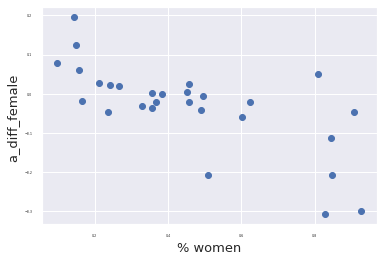

In [320]:
similarity_vs_tpr(tprs_change_debias, '', 'a', prof2fem)

### RMS

In [133]:
def rms_diff(tpr_diff):
    return np.sqrt(np.mean(tpr_diff**2))

In [154]:
print('before', rms_diff(np.array(list(tprs_change_biased.values()))))
print('after', rms_diff(np.array(list(tprs_change_debias.values()))))

before 0.1777996087888496
after 0.11395411427403379


### Perform finetuning

In [ ]:
clf.fit(X_train.dot(P), Y_train)

#### test again

In [ ]:
print(clf.score(X_dev.dot(P), Y_dev))